In [1]:
from cc.env.collect import sample_feedforward_and_collect
from cc.env import make_env
from cc.examples.neural_ode_model_compact_example import make_neural_ode_model
from cc.env.wrappers import TransformWrapper
from cc.train import (
    ModelControllerTrainer, TrainingOptionsModel, 
    EvaluationMetrices, Tracker, make_dataloader, DictLogger,
    Regularisation, SupervisedDataset, UnsupervisedDataset
)
import jax.random as jrand
from cc.utils import rmse, l2_norm
import optax
import jax.numpy as jnp
from cc.env.wrappers import ReplacePhysicsByModelWrapper
from cc.examples.feedforward_controller import make_feedforward_controller
from cc.env.collect import collect
from cc.utils.utils import timestep_array_from_env
import matplotlib.pyplot as plt
from cc.train import TrainingOptionsController
from cc.examples.neural_ode_controller_compact_example import make_neural_ode_controller
from cc.env.collect import random_steps_source
from cc.env.wrappers import AddRefSignalRewardFnWrapper
import jax
from cc.env.collect import collect_exhaust_source
from cc.env.collect import sample_feedforward_collect_and_make_source

In [2]:
time_limit = 5.0
control_timestep = 0.01

def _tanh_transform(u):
    # the division by 6 here is actually required, but our transform is without it
    return 6*jnp.tanh(u / 6)

env = make_env("muscle_cocontraction", time_limit=time_limit, control_timestep=control_timestep, random=1)
env = TransformWrapper(env, f_action=_tanh_transform)

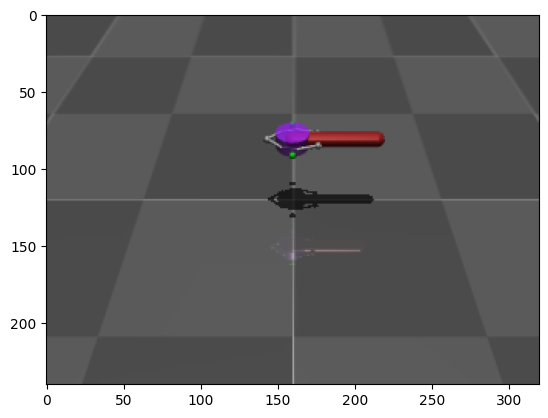

In [3]:
# for an animation look here https://github.com/SimiPixel/chain_control/tree/main/cc/env#co-contraction-of-muscle-model
plt.imshow(env.physics.render())

In [4]:
sample_train = sample_feedforward_and_collect(
    env,
    seeds_gp=[0,1,2,3],
    seeds_cos=[2,]
)

sample_val = sample_feedforward_and_collect(
    env, 
    seeds_gp=[15,],
)

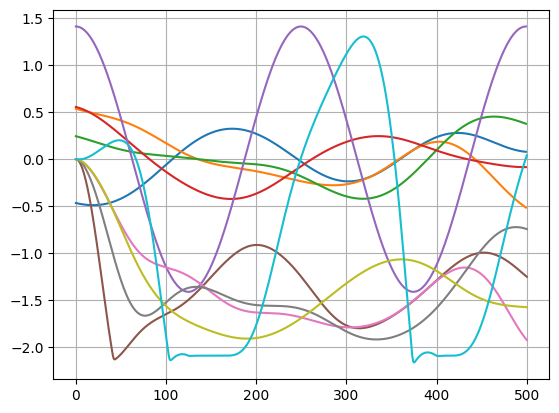

In [5]:
# for this system the maximal output is two radians
plt.plot(sample_train.action[..., 0].T)
plt.plot(sample_train.obs["endeffector_phi_rad"][..., 0].T)
plt.grid()

In [6]:
model = make_neural_ode_model(
    env.action_spec(),
    env.observation_spec(),
    env.control_timestep(),
    state_dim=10,
    f_depth=0, 
    f_final_activation=jnp.tanh,
    u_transform=_tanh_transform
)

In [7]:
model_train_dataloader = make_dataloader(
    SupervisedDataset(sample_train.action, sample_train.obs), # <- (X, y)
    jrand.PRNGKey(2,), 
    n_minibatches=5
)

optimizer = optax.adam(1e-3)

metrices = (
    EvaluationMetrices(
        data = (sample_val.action, sample_val.obs), # <- (X, y)
        metrices=(
            lambda y, yhat: {"val_rmse": rmse(y, yhat)}, 
        )
    ),
)

model_train_options = TrainingOptionsModel(
    model_train_dataloader, 
    optimizer, 
    metrices=metrices
)

model_trainer = ModelControllerTrainer(
    model, 
    model_train_options=model_train_options,
    loggers=[DictLogger()],
    trackers=[Tracker("val_rmse")]
)

In [8]:
model_trainer.run(1500)
fitted_model = model_trainer.trackers[0].best_model_or_controller()

  0%|          | 0/1500 [00:00<?, ?it/s]

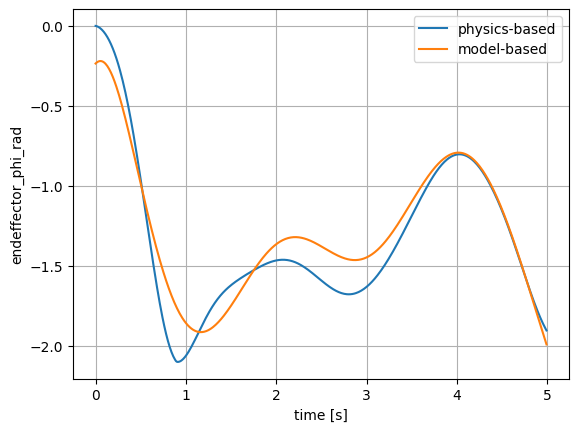

In [9]:
env_model = ReplacePhysicsByModelWrapper(env, fitted_model)
controller = make_feedforward_controller(sample_val.action[0])
pred_sample, _ = collect(env_model, controller)
ts = timestep_array_from_env(env)
plt.plot(ts, sample_val.obs["endeffector_phi_rad"][0, :-1], label="physics-based")
plt.plot(ts, pred_sample.obs["endeffector_phi_rad"][0, :-1], label = "model-based")
plt.xlabel("time [s]")
plt.ylabel("endeffector_phi_rad")
plt.legend()
plt.grid()

# Training a controller

In [10]:
source = random_steps_source(env, seeds=list(range(30)), max_abs_amplitude=2)
env_w_source = AddRefSignalRewardFnWrapper(env, source)

In [11]:
controller = make_neural_ode_controller(
    env_w_source.observation_spec(),
    env.action_spec(),
    env.control_timestep(),
    5,
    f_depth=0,
    superposition=True,
)

def tree_transform(bound: float = 2.0):
    upper_bound = bound
    lower_bound = -bound

    @jax.vmap
    def _random_step(ref, key):
        return jnp.ones_like(ref) * jrand.uniform(
            key, (), minval=lower_bound, maxval=upper_bound
        )

    def _tree_transform(key, ref, bs):
        keys = jrand.split(key, bs)
        return jax.tree_map(lambda ref: _random_step(ref, keys), ref)

    return _tree_transform

controller_dataloader = make_dataloader(
    UnsupervisedDataset(source.get_references_for_optimisation()),
    jrand.PRNGKey(1,),
    n_minibatches=5,
    tree_transform=tree_transform()
)

optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(1e-3))
regularisers = (
    Regularisation(
        prefactor = 0.001,
        reduce_weights = lambda vector_of_params: {"l2_norm": l2_norm(vector_of_params)}
    ),
)
controller_train_options = TrainingOptionsController(
    controller_dataloader, optimizer, regularisers=regularisers
)

controller_trainer = ModelControllerTrainer(
    fitted_model, controller, controller_train_options=controller_train_options, 
    trackers=[], loggers=[DictLogger()]
)

This model has been registered with model name `model0`.
                    When using multiple models individual model names have to
                    be provided by passing a dictionary in the `model` argument


In [12]:
controller_trainer.run(3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

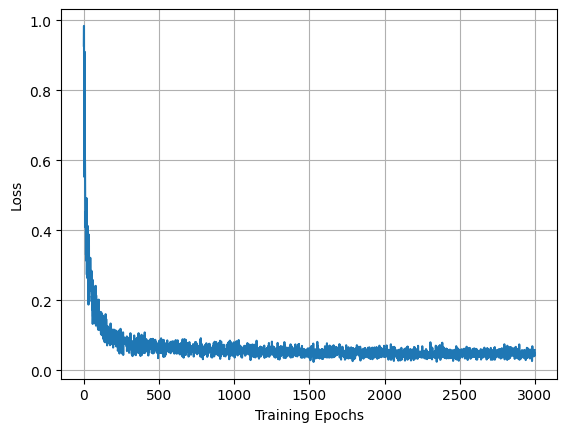

In [13]:
plt.plot(controller_trainer.get_logs()[0]["loss"])
plt.grid()
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.show()

In [14]:
fitted_controller = controller_trainer._controller

eval_source = sample_feedforward_collect_and_make_source(env, seeds=[21, 22, 23, 24])[0]
controller_performance_sample, loop_results = collect_exhaust_source(
    AddRefSignalRewardFnWrapper(env, eval_source), fitted_controller)
jnp.mean(-controller_performance_sample.rew)

Reference Iterator:   0%|          | 0/4 [00:00<?, ?it/s]

Array(0.00605994, dtype=float32)

Text(0.5, 0, 'Timesteps')

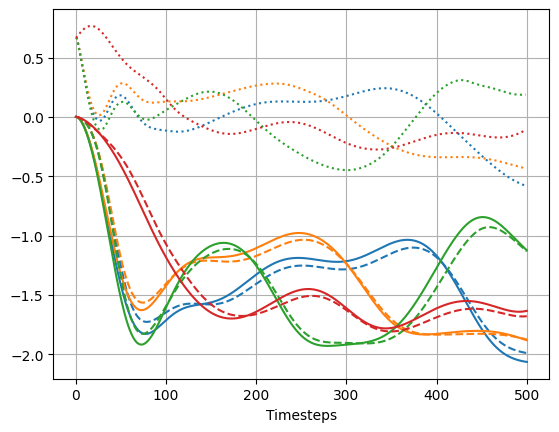

In [15]:
import matplotlib.pyplot as plt 

for i in range(4):
    plt.plot(controller_performance_sample.action[i], color=f"C{i}", linestyle="dotted")
    plt.plot(controller_performance_sample.obs["obs"]["endeffector_phi_rad"][i], color=f"C{i}", linestyle="dashed")
    plt.plot(controller_performance_sample.obs["ref"]["endeffector_phi_rad"][i], color=f"C{i}")

plt.grid()
plt.xlabel("Timesteps")